In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn    as sns
from sklearn               import model_selection as ms
from sklearn               import ensemble        as en
from sklearn               import preprocessing as pp

In [2]:
cols = ['idcsdmpessoa','Receita','Inatividade','Compras','mesesCadastro','vlrCLV']
clientes_outubro = pd.read_csv("clientes_outubro.csv", names=cols,sep=';',low_memory=False)

df1 = clientes_outubro.copy()

In [3]:
df1['vlrCLV'] = df1['vlrCLV'].str.replace(',', '.').astype(float)
df1.head()

,idcsdmpessoa,Receita,Inatividade,Compras,mesesCadastro,vlrCLV
0,4506,387.9420,20,7,63,905.482003
1,5521,4666.7395,20,25,63,10976.409685
2,422022,4630.0577,17,32,62,12074.046757
3,423314,2891.8703,65,22,252,7874.528815
4,423812,764.3719,6,12,213,2007.965663


In [ ]:
var = 'Receita'

In [ ]:
sns.displot(df1[var]);

In [ ]:
sns.boxplot(df1[var]);

In [4]:
#Simulando os dados que vem em produção
X = df1.drop('vlrCLV',axis=1)

#Guardando a variável resposta
Y = df1['vlrCLV'].copy()

#Separando de forma aleatória os dados que vão para o treino e os que vão para o teste
x_train, x_validation, y_train, y_validation = ms.train_test_split(X,Y,test_size=0.20)

#Juntando os dados de treino com a variável resposta do treino
df5 = pd.concat([x_train,y_train],axis=1)

In [ ]:
mm = pp.MinMaxScaler() #Mantem a mesma distribuição, com outro shape, e colocando de 0 a 1
ss = pp.StandardScaler() #Rescala os dados
rs = pp.RobustScaler()


df5['Receita'] = mm.fit_transform(df5[['Receita']]) 
df5['Inatividade'] = mm.fit_transform(df5[['Inatividade']])
df5['Receita'] = mm.fit_transform(df5[['Compras']]) 
df5['Inatividade'] = mm.fit_transform(df5[['mesesCadastro']])

x_validation['Receita'] = mm.fit_transform(x_validation[['Receita']]) 
x_validation['Inatividade'] = mm.fit_transform(x_validation[['Inatividade']])
x_validation['Receita'] = mm.fit_transform(x_validation[['Compras']]) 
x_validation['Inatividade'] = mm.fit_transform(x_validation[['mesesCadastro']])

In [5]:
#model definition
forest = en.RandomForestRegressor(n_estimators=100, random_state=0,n_jobs=-1)

#data preparation
x_train_n = df5.drop(['idcsdmpessoa','vlrCLV'],axis=1)
y_train_n = y_train.values

forest.fit(x_train_n,y_train_n)

RandomForestRegressor(n_jobs=-1, random_state=0)

Feature Ranking
         feature  importance
0        Receita    0.992888
0    Inatividade    0.003482
0  mesesCadastro    0.002300
0        Compras    0.001330


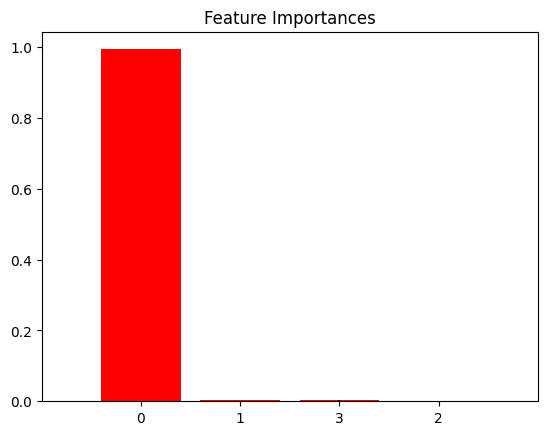

In [6]:
importances = forest.feature_importances_ #Salva as importâncias das features
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1] #Importâncias das árvores ordenadas pelo maior valor

#print the feature ranking
print('Feature Ranking')
df = pd.DataFrame()
for i,j in zip(x_train_n,forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j},index=[0])
    df = pd.concat([df,aux],axis=0)
    
print(df.sort_values('importance',ascending=False))

#Plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature Importances')
plt.bar(range(x_train_n.shape[1]),importances[indices],color='r',yerr=std[indices],align='center')
plt.xticks(range(x_train_n.shape[1]),indices)
plt.xlim([-1,x_train_n.shape[1]])
plt.show()